# Properties of transfer matrices induced by unitaries

Created 06/06/2024

Objectives:
* When acting with the transfer matrices derived from unitaries on these states, are there extra requirements?
    * Vector norm less than or equal to one?
    * Is there only a subspace of the entire space accessible?
    * Compare transfer matrices from unitaries with more general operators. What properties do transfer matrices from unitaries have?

# Package imports

In [1]:
from functools import reduce
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from SPTOptimization.super_fibonacci import super_fibonacci

In [4]:
from SPTOptimization.utils import (
    get_transfer_matrix_from_unitary,
    get_transfer_matrices_from_unitary_list,
    multiply_transfer_matrices,
    to_npc_array
)

# Load data

In [5]:
DATA_DIR = r"data/transverse_cluster_200_site_dmrg"

In [6]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [7]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [8]:
psi_dict = dict()

In [9]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

In [10]:
list(psi_dict)

[0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0]

In [11]:
test_psi = psi_dict[0.5]

# Definitions

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
base_unitaries = np.array([np_I, 1j*np_X, 1j*np_Y, 1j*np_Z])

In [14]:
def get_symmetry_tm(psi, symmetry_operations):
    index = (psi.L - len(symmetry_operations))//2

    tms = get_transfer_matrices_from_unitary_list(
        psi,
        symmetry_operations,
        index
    )

    transfer_matrix = reduce(
        multiply_transfer_matrices,
        tms
    )

    np_transfer_matrix = (
        transfer_matrix
        .combine_legs([['vL', 'vL*'], ['vR', 'vR*']])
        .to_ndarray()
    )

    return np_transfer_matrix

In [15]:
def get_left_right_projected_states(symmetry_transfer_matrix):
    U, S, Vh = np.linalg.svd(symmetry_transfer_matrix)

    return (S[0], U[:, 0], Vh[0])

# Code
## Testing

In [16]:
symmetry_tms = [
    get_symmetry_tm(psi, [np_X, np_I]*40)
    for psi in psi_dict.values()
]

In [17]:
def get_base_transfer_matrices(psi, site_index):
    X = np.array([
        get_transfer_matrix_from_unitary(psi, u, site_index)
        .combine_legs([['vL', 'vL*'], ['vR', 'vR*']])
        .to_ndarray()
        for u in base_unitaries
    ])

    return X

In [18]:
def operator_norm(X):
    return np.linalg.SVD(X).S[0]

In [19]:
base_index = (test_psi.L + 80)//2

In [20]:
base_index

140

In [21]:
base_transfer_matrices = get_base_transfer_matrices(test_psi, base_index)

In [22]:
base_transfer_matrices.shape

(4, 64, 64)

In [23]:
sing_vals = np.round(np.linalg.svd(base_transfer_matrices).S, 3)

In [24]:
(
    Counter(sing_vals[0]),
    Counter(sing_vals[1]),
    Counter(sing_vals[2]),
    Counter(sing_vals[3])
)

(Counter({1.39: 16, 0.259: 16, 0.033: 16, 0.006: 16}),
 Counter({1.39: 16, 0.259: 16, 0.033: 16, 0.006: 16}),
 Counter({0.0: 32, 1.39: 16, 0.261: 16}),
 Counter({0.0: 32, 1.39: 16, 0.261: 16}))

In [25]:
s3_points = super_fibonacci(int(2e4))
s3_search_points = s3_points[s3_points[:, 0] >=  0]

In [26]:
s3_points.shape

(20000, 4)

In [27]:
test_symmetry_tm = symmetry_tms[5]

In [28]:
*_, test_right_projected_state = get_left_right_projected_states(test_symmetry_tm)

In [29]:
test_right_projected_state.shape

(64,)

In [30]:
np.linalg.norm(test_right_projected_state)

1.0

In [31]:
test_next_base_points = np.tensordot(
    test_right_projected_state,
    base_transfer_matrices,
    [[0,], [1,]]
)

In [32]:
np.linalg.norm(test_next_base_points, axis=1)

array([0.25989061, 1.        , 0.96532736, 0.02449415])

In [33]:
test_next_base_points.shape

(4, 64)

In [34]:
test_next_points = np.tensordot(
    s3_search_points,
    test_next_base_points,
    [[1,], [0,]]
)

In [35]:
test_next_points.shape

(10003, 64)

In [36]:
test_next_points_norm = np.linalg.norm(test_next_points, axis=1)

In [37]:
pd.Series(test_next_points_norm).describe()

count    10003.000000
mean         0.673947
std          0.213655
min          0.032207
25%          0.516259
50%          0.707193
75%          0.855978
max          0.999486
dtype: float64

In [38]:
next_base_transfer_matrices = get_base_transfer_matrices(test_psi, base_index+1)

In [39]:
next_sing_vals = np.round(np.linalg.svd(next_base_transfer_matrices).S, 3)

In [40]:
(
    Counter(next_sing_vals[0]),
    Counter(next_sing_vals[1]),
    Counter(next_sing_vals[2]),
    Counter(next_sing_vals[3])
)

(Counter({1.39: 16, 0.259: 16, 0.033: 16, 0.006: 16}),
 Counter({1.39: 16, 0.259: 16, 0.033: 16, 0.006: 16}),
 Counter({0.0: 32, 1.39: 16, 0.261: 16}),
 Counter({0.0: 32, 1.39: 16, 0.261: 16}))

In [41]:
test_2_base_points = np.tensordot(
    test_next_points,
    base_transfer_matrices,
    [[1,], [1,]]
)

In [42]:
test_2_base_points.shape

(10003, 4, 64)

In [43]:
test_2_points = np.tensordot(
    s3_search_points[3::5],
    test_2_base_points[2::5],
    [[1,], [1,]]
)

In [44]:
test_2_points.shape

(2000, 2001, 64)

In [45]:
test_2_norms = np.linalg.norm(test_2_points, axis=-1)

In [46]:
pd.Series(test_2_norms.flatten()).describe()

count    4.002000e+06
mean     4.517203e-01
std      2.093431e-01
min      1.173027e-02
25%      2.844637e-01
50%      4.380686e-01
75%      6.093696e-01
max      9.977682e-01
dtype: float64

In [47]:
max_2_norms = np.max(test_2_norms, axis=0)

In [48]:
max_2_norms.shape

(2001,)

In [49]:
norm_2_1_ratio = max_2_norms/test_next_points_norm[2::5]

In [50]:
norm_2_1_ratio.shape

(2001,)

In [51]:
pd.Series(norm_2_1_ratio).describe()

count    2001.000000
mean        0.998553
std         0.001990
min         0.997837
25%         0.998200
50%         0.998355
75%         0.998613
max         1.082165
dtype: float64

## Right side

In [52]:
s3_points = super_fibonacci(int(4e3))
s3_search_points = s3_points[s3_points[:, 0] >=  0]

In [53]:
s3_points.shape

(4000, 4)

In [54]:
def describe_1d_array(X):
    return pd.Series(X).describe()

In [55]:
def check_ratios_and_distances(psi, right_projected_state):
    base_transfer_matrices_1 = get_base_transfer_matrices(psi, base_index)
    base_transfer_matrices_2 = get_base_transfer_matrices(psi, base_index+1)

    base_sing_vals_1 = np.round(np.linalg.svd(base_transfer_matrices_1).S, 3)
    base_sing_vals_2 = np.round(np.linalg.svd(base_transfer_matrices_2).S, 3)

    base_points_1 = np.tensordot(
        right_projected_state,
        base_transfer_matrices_1,
        [[0,], [1,]]
    )
    
    virtual_points_1 = np.tensordot(
        s3_search_points,
        base_points_1,
        [[1,], [0,]]
    )

    norm_virtual_points_1 = np.linalg.norm(virtual_points_1, axis=-1)
    norms_1_stats = describe_1d_array(norm_virtual_points_1)

    base_points_2 = np.tensordot(
        virtual_points_1,
        base_transfer_matrices_2,
        [[1,], [1,]]
    )

    stride_length = 10

    norms_2 = np.zeros((len(s3_search_points), len(virtual_points_1)))
    ratios = np.zeros((len(virtual_points_1,)))

    steps = len(virtual_points_1)//stride_length

    for i in range(steps):
        virtual_2_points = np.tensordot(
            s3_search_points,
            base_points_2[stride_length*i:stride_length*(i+1)],
            [[1,], [1,]]
        )

        norms = np.linalg.norm(virtual_2_points, axis=2)
        norms_2[:, stride_length*i:stride_length*(i+1)] = norms
        
        max_virtual_2_norms = np.max(norms, axis=0)
        norms_ratio = max_virtual_2_norms/norm_virtual_points_1[stride_length*i:stride_length*(i+1)]

        ratios[stride_length*i:stride_length*(i+1)] = norms_ratio

    ratios_desc = describe_1d_array(ratios)
    norms_2_stats = describe_1d_array(norms_2.flatten())

    return {
        "base_sing_vals_1": base_sing_vals_1,
        "base_sing_vals_2": base_sing_vals_2,
        "norms_1": norm_virtual_points_1,
        "norm_virtual_points_1_stats": norms_1_stats,
        "max_norms_2": np.max(norms_2, axis=0),
        "norm_virtual_points_2_stats": norms_2_stats,
        "2_to_1_ratios_stats": ratios_desc
    }

In [56]:
d = check_ratios_and_distances(test_psi, test_right_projected_state)

In [57]:
d['2_to_1_ratios_stats']

count    2003.000000
mean        0.898473
std         0.087258
min         0.000000
25%         0.837059
50%         0.916340
75%         0.972151
max         0.999461
dtype: float64

In [58]:
d['norm_virtual_points_2_stats']

count    4.012009e+06
mean     4.659019e-01
std      1.793924e-01
min      0.000000e+00
25%      3.289117e-01
50%      4.670930e-01
75%      6.009182e-01
max      9.980977e-01
dtype: float64

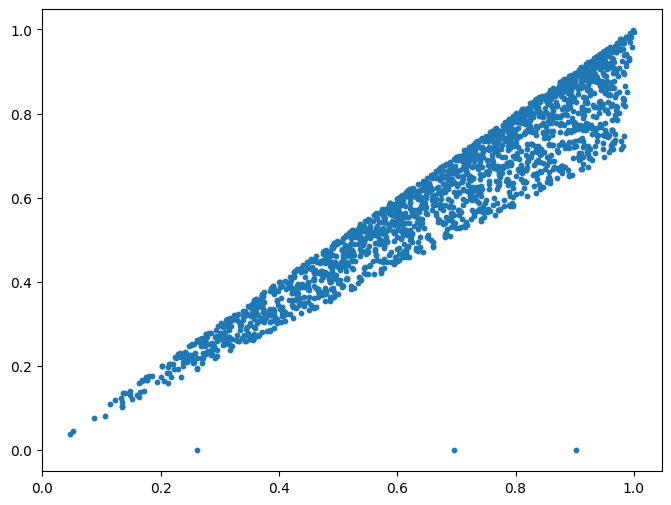

In [59]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

In [60]:
left_projected_states = list()
right_projected_states = list()

for tm in symmetry_tms:
    _, left_projected_state, right_projected_state = (
        get_left_right_projected_states(tm)
    )

    left_projected_states.append(left_projected_state)
    right_projected_states.append(right_projected_state)

In [61]:
right_ratios_and_norms = [
    check_ratios_and_distances(psi, right_projected_state)
    for psi, right_projected_state in zip(psi_dict.values(), right_projected_states)
]

### Singular values 1

In [62]:
right_ratios_and_norms[0]["base_sing_vals_1"]

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [63]:
right_ratios_and_norms[1]["base_sing_vals_1"]

array([[1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-

In [64]:
right_ratios_and_norms[5]["base_sing_vals_1"]

array([[1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006],
       [1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.00

In [65]:
right_ratios_and_norms[9]["base_sing_vals_1"]

array([[1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054],
       [1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.05

In [66]:
right_ratios_and_norms[11]["base_sing_vals_1"]

array([[1.392e+00, 1.388e+00, 1.388e+00, 1.385e+00, 1.368e+00, 1.368e+00,
        1.364e+00, 1.364e+00, 1.346e+00, 1.014e+00, 1.014e+00, 1.013e+00,
        1.013e+00, 1.004e+00, 1.003e+00, 1.003e+00, 1.003e+00, 1.002e+00,
        1.002e+00, 1.000e+00, 9.900e-01, 9.820e-01, 9.750e-01, 9.400e-01,
        9.400e-01, 2.910e-01, 2.870e-01, 2.870e-01, 2.820e-01, 2.720e-01,
        2.720e-01, 2.650e-01, 2.650e-01, 2.460e-01, 1.830e-01, 1.770e-01,
        1.710e-01, 1.680e-01, 1.680e-01, 1.680e-01, 1.680e-01, 1.680e-01,
        1.450e-01, 1.450e-01, 1.440e-01, 1.440e-01, 6.400e-02, 6.200e-02,
        6.200e-02, 6.000e-02, 5.700e-02, 5.700e-02, 5.400e-02, 5.400e-02,
        5.100e-02, 1.300e-02, 1.300e-02, 1.300e-02, 1.300e-02, 1.100e-02,
        1.100e-02, 1.100e-02, 1.100e-02, 9.000e-03],
       [1.392e+00, 1.388e+00, 1.388e+00, 1.385e+00, 1.368e+00, 1.368e+00,
        1.364e+00, 1.364e+00, 1.346e+00, 1.014e+00, 1.014e+00, 1.013e+00,
        1.013e+00, 1.004e+00, 1.003e+00, 1.003e+00, 1.003e+

In [67]:
right_ratios_and_norms[15]["base_sing_vals_1"]

array([[1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.003, 0.003,
        0.003],
       [1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.00

In [68]:
right_ratios_and_norms[20]["base_sing_vals_1"]

array([[1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 9.990e-01, 9.990e-01, 9.990e-01,
        9.990e-01, 3.830e-01, 2.900e-01, 2.900e-01, 2.900e-01, 2.900e-01,
        2.600e-01, 2.600e-01, 2.600e-01, 2.600e-01, 1.330e-01, 7.800e-02,
        7.800e-02, 7.800e-02, 7.800e-02, 4.800e-02, 4.800e-02, 4.800e-02,
        4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 3.700e-02,
        2.800e-02, 2.800e-02, 2.800e-02, 2.800e-02, 1.600e-02, 1.600e-02,
        1.600e-02, 1.600e-02, 6.000e-03, 6.000e-03, 6.000e-03, 6.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03],
       [1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+

Conclusions:
* The 4 groups of 16 fold degenerate singular values seems peculiar to the non trivial phase, and so is likely a result of entanglement spectrum degeneracy.
* Regardless of B, the transfer matrices seem to have a similar maximum singular value (operator norm) of about 1.4

### Singular values 2

In [69]:
right_ratios_and_norms[0]["base_sing_vals_2"]

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [70]:
right_ratios_and_norms[1]["base_sing_vals_2"]

array([[1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-

In [71]:
right_ratios_and_norms[5]["base_sing_vals_2"]

array([[1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006],
       [1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.00

In [72]:
right_ratios_and_norms[9]["base_sing_vals_2"]

array([[1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054],
       [1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.05

In [73]:
right_ratios_and_norms[11]["base_sing_vals_2"]

array([[1.354, 1.305, 1.305, 1.269, 1.204, 1.204, 1.187, 1.186, 1.136,
        1.002, 1.002, 1.002, 1.001, 1.001, 0.999, 0.997, 0.996, 0.996,
        0.993, 0.969, 0.969, 0.964, 0.963, 0.963, 0.962, 0.823, 0.753,
        0.748, 0.666, 0.666, 0.644, 0.644, 0.642, 0.642, 0.609, 0.464,
        0.464, 0.422, 0.399, 0.399, 0.396, 0.396, 0.305, 0.267, 0.255,
        0.21 , 0.168, 0.163, 0.162, 0.136, 0.135, 0.134, 0.133, 0.092,
        0.092, 0.079, 0.064, 0.064, 0.053, 0.053, 0.041, 0.023, 0.023,
        0.007],
       [1.354, 1.305, 1.305, 1.269, 1.204, 1.204, 1.187, 1.186, 1.136,
        1.002, 1.002, 1.002, 1.001, 1.001, 0.999, 0.997, 0.996, 0.996,
        0.993, 0.969, 0.969, 0.964, 0.963, 0.963, 0.962, 0.823, 0.753,
        0.748, 0.666, 0.666, 0.644, 0.644, 0.642, 0.642, 0.609, 0.464,
        0.464, 0.422, 0.399, 0.399, 0.396, 0.396, 0.305, 0.267, 0.255,
        0.21 , 0.168, 0.163, 0.162, 0.136, 0.135, 0.134, 0.133, 0.092,
        0.092, 0.079, 0.064, 0.064, 0.053, 0.053, 0.041, 0.02

In [74]:
right_ratios_and_norms[15]["base_sing_vals_2"]

array([[1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.003, 0.003,
        0.003],
       [1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.00

In [75]:
right_ratios_and_norms[20]["base_sing_vals_2"]

array([[1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 9.990e-01, 9.990e-01, 9.990e-01,
        9.990e-01, 3.830e-01, 2.900e-01, 2.900e-01, 2.900e-01, 2.900e-01,
        2.600e-01, 2.600e-01, 2.600e-01, 2.600e-01, 1.330e-01, 7.800e-02,
        7.800e-02, 7.800e-02, 7.800e-02, 4.800e-02, 4.800e-02, 4.800e-02,
        4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 3.700e-02,
        2.800e-02, 2.800e-02, 2.800e-02, 2.800e-02, 1.600e-02, 1.600e-02,
        1.600e-02, 1.600e-02, 6.000e-03, 6.000e-03, 6.000e-03, 6.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03],
       [1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+

Conclusions:
* No change from previous case 

### Norms of first virtual points

In [76]:
for i, d in enumerate(right_ratios_and_norms):
    print("\n i={}".format(i))
    print(d["norm_virtual_points_1_stats"])


 i=0
count    2003.000000
mean        0.665942
std         0.235971
min         0.012002
25%         0.495106
50%         0.710266
75%         0.863463
max         0.999679
dtype: float64

 i=1
count    2003.000000
mean        0.666329
std         0.234877
min         0.014683
25%         0.495524
50%         0.710240
75%         0.863287
max         0.999667
dtype: float64

 i=2
count    2003.000000
mean        0.667377
std         0.231887
min         0.021026
25%         0.497994
50%         0.710183
75%         0.862632
max         0.999632
dtype: float64

 i=3
count    2003.000000
mean        0.668953
std         0.227307
min         0.029360
25%         0.500487
50%         0.709096
75%         0.862163
max         0.999572
dtype: float64

 i=4
count    2003.000000
mean        0.670967
std         0.221303
min         0.039360
25%         0.506328
50%         0.709320
75%         0.859121
max         0.999484
dtype: float64

 i=5
count    2003.000000
mean        0.673358
std    

Concluisons:
Wide spread in values across the board.

### Max of norm of second virtual points against norm of first virtual point

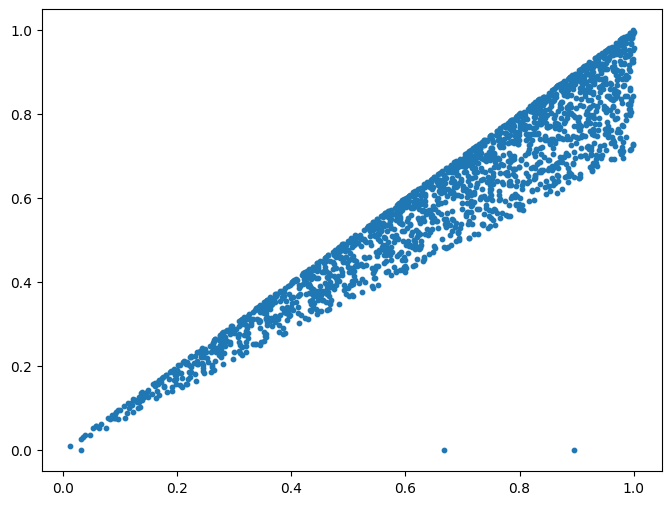

In [77]:
i = 0
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

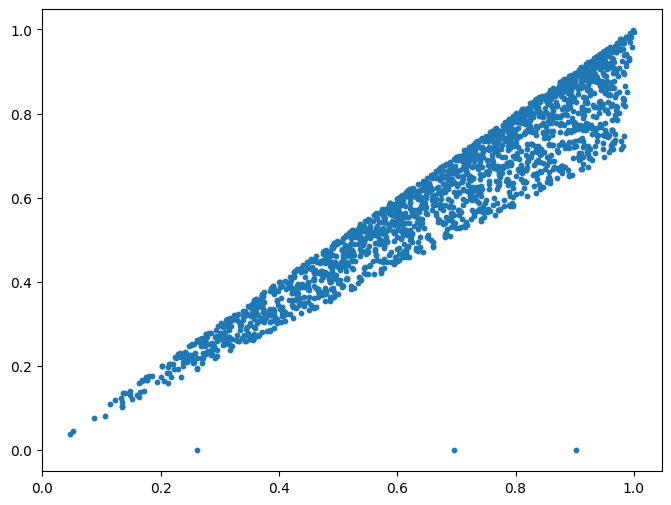

In [78]:
i = 5
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

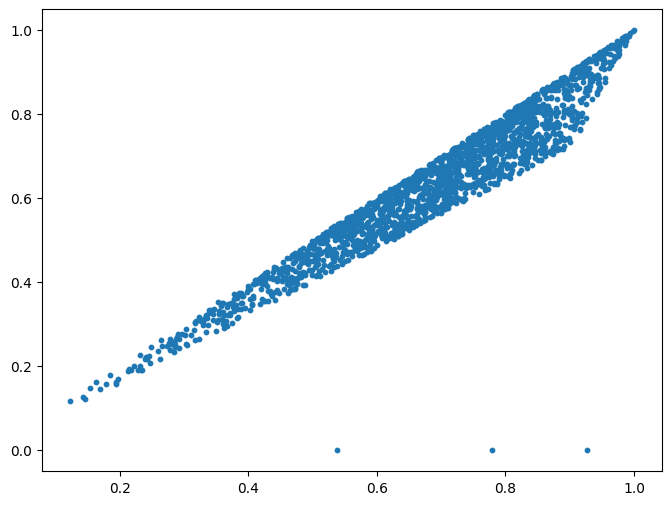

In [79]:
i = 9
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

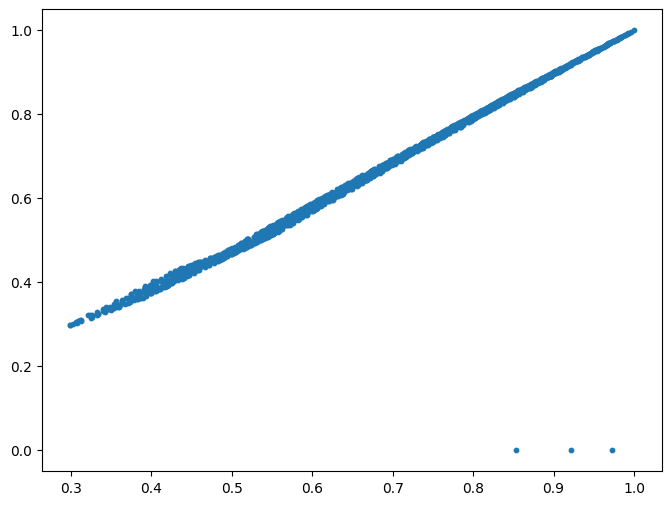

In [80]:
i = 11
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

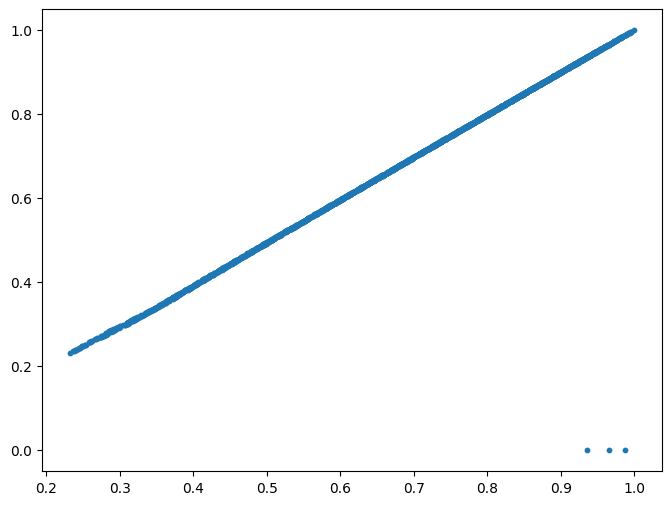

In [81]:
i = 15
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

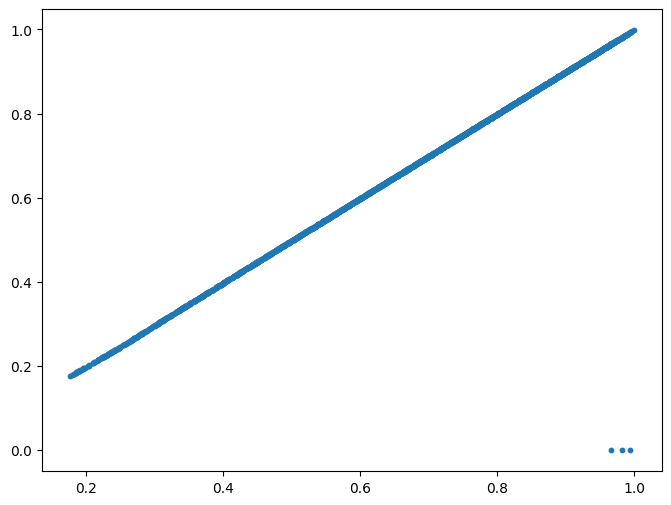

In [82]:
i = 20
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

Conclusions:
* Interesting "tightening" of the spread depending on B.
* In general, a lower prior norm implies a lower future norm. This is surprising, considering the operator norms of the transfer matrices are about 1.4.

### Ratio of norms

In [83]:
for i, d in enumerate(right_ratios_and_norms):
    print("\n i={}".format(i))
    print(d["2_to_1_ratios_stats"])


 i=0
count    2003.000000
mean        0.899101
std         0.093978
min         0.000000
25%         0.831999
50%         0.923894
75%         0.980612
max         0.999928
dtype: float64

 i=1
count    2003.000000
mean        0.898333
std         0.093452
min         0.000000
25%         0.831543
50%         0.922969
75%         0.978851
max         0.999638
dtype: float64

 i=2
count    2003.000000
mean        0.897450
std         0.092682
min         0.000000
25%         0.831474
50%         0.920738
75%         0.976595
max         0.999602
dtype: float64

 i=3
count    2003.000000
mean        0.897031
std         0.091322
min         0.000000
25%         0.832442
50%         0.918371
75%         0.974943
max         0.999541
dtype: float64

 i=4
count    2003.000000
mean        0.897327
std         0.089439
min         0.000000
25%         0.834298
50%         0.916457
75%         0.973301
max         0.999467
dtype: float64

 i=5
count    2003.000000
mean        0.898473
std    

Conclusions:
* All pretty much bounded with max 1, how weird.

## Left side

In [84]:
base_index = (test_psi.L - 80)//2 -1

In [85]:
def left_check_ratios_and_distances(psi, left_projected_state):
    base_transfer_matrices_1 = get_base_transfer_matrices(psi, base_index)
    base_transfer_matrices_2 = get_base_transfer_matrices(psi, base_index-1)

    base_sing_vals_1 = np.round(np.linalg.svd(base_transfer_matrices_1).S, 3)
    base_sing_vals_2 = np.round(np.linalg.svd(base_transfer_matrices_2).S, 3)

    base_points_1 = np.tensordot(
        left_projected_state,
        base_transfer_matrices_1,
        [[0,], [2,]]
    )
    
    virtual_points_1 = np.tensordot(
        s3_search_points,
        base_points_1,
        [[1,], [0,]]
    )

    norm_virtual_points_1 = np.linalg.norm(virtual_points_1, axis=-1)
    norms_1_stats = describe_1d_array(norm_virtual_points_1)

    base_points_2 = np.tensordot(
        virtual_points_1,
        base_transfer_matrices_2,
        [[1,], [2,]]
    )

    stride_length = 10

    norms_2 = np.zeros((len(s3_search_points), len(virtual_points_1)))
    ratios = np.zeros((len(virtual_points_1,)))

    steps = len(virtual_points_1)//stride_length

    for i in range(steps):
        virtual_2_points = np.tensordot(
            s3_search_points,
            base_points_2[stride_length*i:stride_length*(i+1)],
            [[1,], [1,]]
        )

        norms = np.linalg.norm(virtual_2_points, axis=2)
        norms_2[:, stride_length*i:stride_length*(i+1)] = norms
        
        max_virtual_2_norms = np.max(norms, axis=0)
        norms_ratio = max_virtual_2_norms/norm_virtual_points_1[stride_length*i:stride_length*(i+1)]

        ratios[stride_length*i:stride_length*(i+1)] = norms_ratio

    ratios_desc = describe_1d_array(ratios)
    norms_2_stats = describe_1d_array(norms_2.flatten())

    return {
        "base_sing_vals_1": base_sing_vals_1,
        "base_sing_vals_2": base_sing_vals_2,
        "norms_1": norm_virtual_points_1,
        "norm_virtual_points_1_stats": norms_1_stats,
        "max_norms_2": np.max(norms_2, axis=0),
        "norm_virtual_points_2_stats": norms_2_stats,
        "2_to_1_ratios_stats": ratios_desc
    }

In [86]:
left_ratios_and_norms = [
    left_check_ratios_and_distances(psi, left_projected_state)
    for psi, left_projected_state in zip(psi_dict.values(), left_projected_states)
]

### Singular values 1

In [87]:
left_ratios_and_norms[0]["base_sing_vals_1"]

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [88]:
left_ratios_and_norms[1]["base_sing_vals_1"]

array([[1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-

In [89]:
left_ratios_and_norms[5]["base_sing_vals_1"]

array([[1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006],
       [1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.00

In [90]:
left_ratios_and_norms[9]["base_sing_vals_1"]

array([[1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054],
       [1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.05

In [91]:
left_ratios_and_norms[11]["base_sing_vals_1"]

array([[1.358, 1.357, 1.357, 1.355, 1.27 , 1.27 , 1.269, 1.269, 1.215,
        1.001, 1.001, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.998,
        0.998, 0.998, 0.997, 0.997, 0.996, 0.996, 0.996, 0.706, 0.546,
        0.546, 0.542, 0.542, 0.505, 0.505, 0.505, 0.505, 0.269, 0.201,
        0.188, 0.188, 0.173, 0.156, 0.132, 0.131, 0.131, 0.13 , 0.112,
        0.111, 0.111, 0.111, 0.077, 0.077, 0.067, 0.064, 0.041, 0.036,
        0.036, 0.034, 0.034, 0.033, 0.028, 0.028, 0.006, 0.005, 0.005,
        0.004],
       [1.358, 1.357, 1.357, 1.355, 1.27 , 1.27 , 1.269, 1.269, 1.215,
        1.001, 1.001, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.998,
        0.998, 0.998, 0.997, 0.997, 0.996, 0.996, 0.996, 0.706, 0.546,
        0.546, 0.542, 0.542, 0.505, 0.505, 0.505, 0.505, 0.269, 0.201,
        0.188, 0.188, 0.173, 0.156, 0.132, 0.131, 0.131, 0.13 , 0.112,
        0.111, 0.111, 0.111, 0.077, 0.077, 0.067, 0.064, 0.041, 0.036,
        0.036, 0.034, 0.034, 0.033, 0.028, 0.028, 0.006, 0.00

In [92]:
left_ratios_and_norms[15]["base_sing_vals_1"]

array([[1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.003, 0.003,
        0.003],
       [1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.00

In [93]:
left_ratios_and_norms[20]["base_sing_vals_1"]

array([[1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 9.990e-01, 9.990e-01, 9.990e-01,
        9.990e-01, 3.830e-01, 2.900e-01, 2.900e-01, 2.900e-01, 2.900e-01,
        2.600e-01, 2.600e-01, 2.600e-01, 2.600e-01, 1.330e-01, 7.800e-02,
        7.800e-02, 7.800e-02, 7.800e-02, 4.800e-02, 4.800e-02, 4.800e-02,
        4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 3.700e-02,
        2.800e-02, 2.800e-02, 2.800e-02, 2.800e-02, 1.600e-02, 1.600e-02,
        1.600e-02, 1.600e-02, 6.000e-03, 6.000e-03, 6.000e-03, 6.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03],
       [1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+

### Singular values 2

In [94]:
left_ratios_and_norms[0]["base_sing_vals_2"]

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [95]:
left_ratios_and_norms[1]["base_sing_vals_2"]

array([[1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-

In [96]:
left_ratios_and_norms[5]["base_sing_vals_2"]

array([[1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006],
       [1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.00

In [97]:
left_ratios_and_norms[9]["base_sing_vals_2"]

array([[1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054],
       [1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.05

In [98]:
left_ratios_and_norms[11]["base_sing_vals_2"]

array([[1.349, 1.348, 1.348, 1.348, 1.261, 1.261, 1.261, 1.261, 1.207,
        1.   , 1.   , 1.   , 1.   , 0.998, 0.998, 0.998, 0.998, 0.996,
        0.996, 0.996, 0.996, 0.994, 0.994, 0.994, 0.994, 0.72 , 0.565,
        0.565, 0.564, 0.564, 0.518, 0.518, 0.518, 0.518, 0.278, 0.248,
        0.246, 0.246, 0.243, 0.166, 0.163, 0.162, 0.162, 0.161, 0.16 ,
        0.159, 0.159, 0.158, 0.095, 0.095, 0.093, 0.093, 0.053, 0.052,
        0.052, 0.052, 0.044, 0.044, 0.043, 0.043, 0.01 , 0.01 , 0.01 ,
        0.01 ],
       [1.349, 1.348, 1.348, 1.348, 1.261, 1.261, 1.261, 1.261, 1.207,
        1.   , 1.   , 1.   , 1.   , 0.998, 0.998, 0.998, 0.998, 0.996,
        0.996, 0.996, 0.996, 0.994, 0.994, 0.994, 0.994, 0.72 , 0.565,
        0.565, 0.564, 0.564, 0.518, 0.518, 0.518, 0.518, 0.278, 0.248,
        0.246, 0.246, 0.243, 0.166, 0.163, 0.162, 0.162, 0.161, 0.16 ,
        0.159, 0.159, 0.158, 0.095, 0.095, 0.093, 0.093, 0.053, 0.052,
        0.052, 0.052, 0.044, 0.044, 0.043, 0.043, 0.01 , 0.01

In [99]:
left_ratios_and_norms[15]["base_sing_vals_2"]

array([[1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.003, 0.003,
        0.003],
       [1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.00

In [100]:
left_ratios_and_norms[20]["base_sing_vals_2"]

array([[1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 9.990e-01, 9.990e-01, 9.990e-01,
        9.990e-01, 3.830e-01, 2.900e-01, 2.900e-01, 2.900e-01, 2.900e-01,
        2.600e-01, 2.600e-01, 2.600e-01, 2.600e-01, 1.330e-01, 7.800e-02,
        7.800e-02, 7.800e-02, 7.800e-02, 4.800e-02, 4.800e-02, 4.800e-02,
        4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 3.700e-02,
        2.800e-02, 2.800e-02, 2.800e-02, 2.800e-02, 1.600e-02, 1.600e-02,
        1.600e-02, 1.600e-02, 6.000e-03, 6.000e-03, 6.000e-03, 6.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03],
       [1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+

Conclusions:
* No change from previous case 

### Norms of first virtual points

In [101]:
for i, d in enumerate(left_ratios_and_norms):
    print("\n i={}".format(i))
    print(d["norm_virtual_points_1_stats"])


 i=0
count    2003.000000
mean        0.667453
std         0.235374
min         0.025355
25%         0.504411
50%         0.703933
75%         0.868833
max         0.999928
dtype: float64

 i=1
count    2003.000000
mean        0.999374
std         0.000362
min         0.998746
25%         0.999065
50%         0.999367
75%         0.999692
max         0.999999
dtype: float64

 i=2
count    2003.000000
mean        0.997468
std         0.001461
min         0.994927
25%         0.996218
50%         0.997441
75%         0.998752
max         0.999995
dtype: float64

 i=3
count    2003.000000
mean        0.994198
std         0.003341
min         0.988364
25%         0.991334
50%         0.994149
75%         0.997130
max         0.999988
dtype: float64

 i=4
count    2003.000000
mean        0.989408
std         0.006082
min         0.978728
25%         0.984187
50%         0.989328
75%         0.994750
max         0.999978
dtype: float64

 i=5
count    2003.000000
mean        0.982847
std    

Concluisons:
Wide spread in values across the board.

### Max of norm of second virtual points against norm of first virtual point

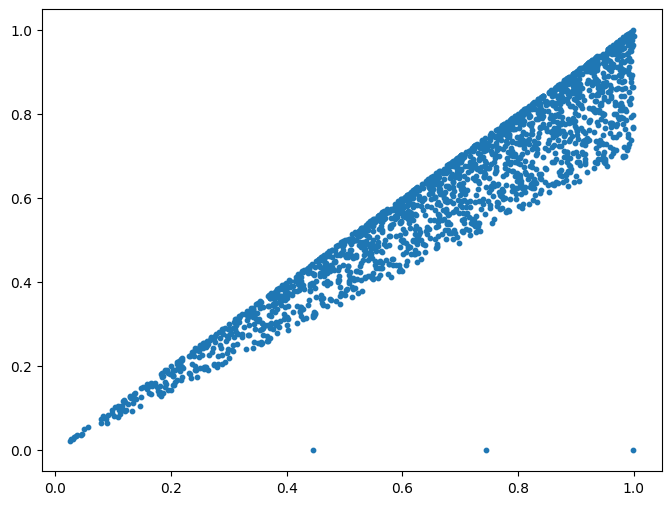

In [102]:
i = 0
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

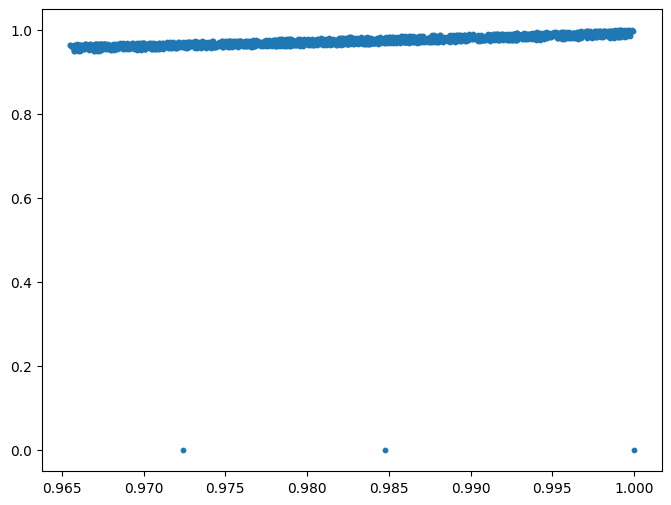

In [103]:
i = 5
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

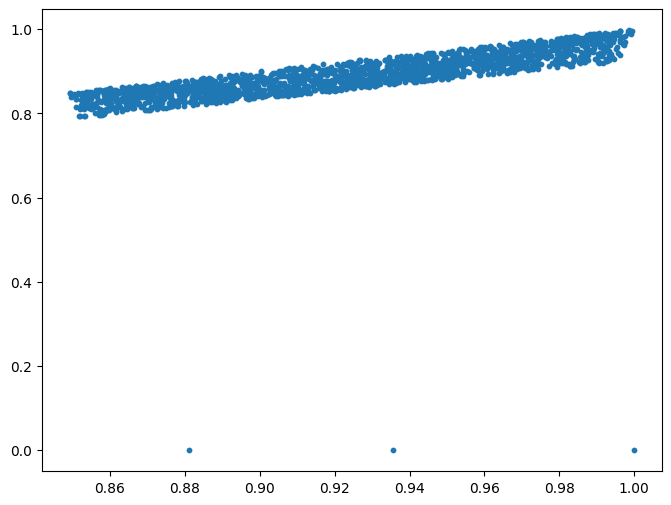

In [104]:
i = 9
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

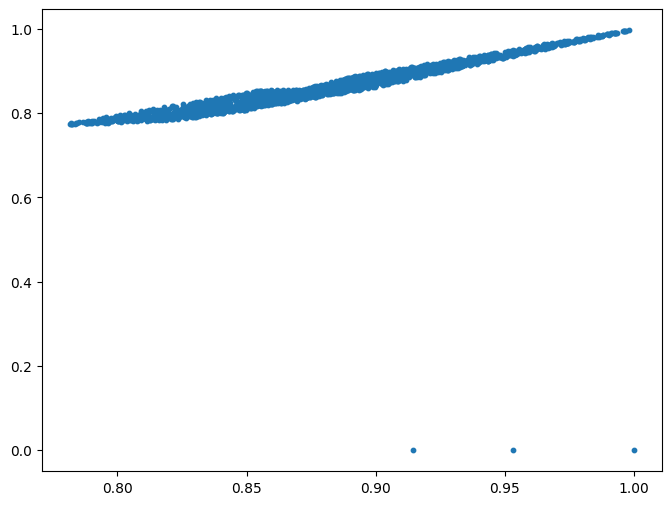

In [105]:
i = 11
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

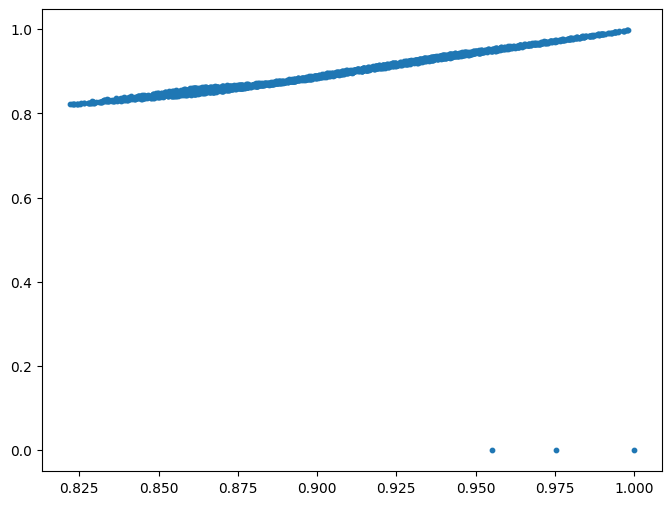

In [106]:
i = 15
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

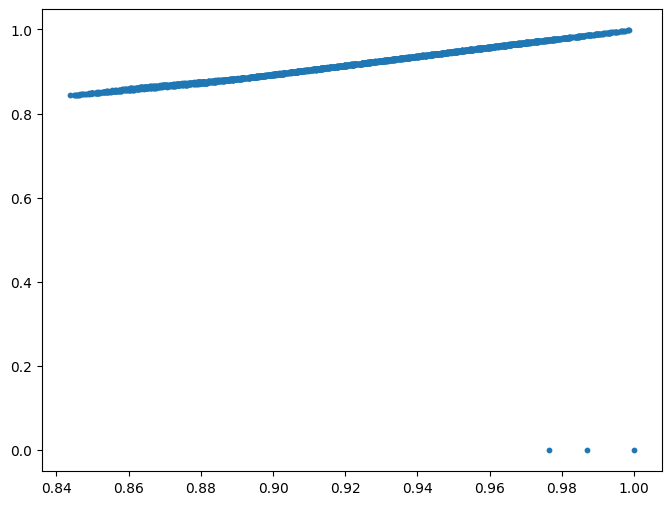

In [107]:
i = 20
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

Conclusions:
* Quite different behaviour to right side. Makes sense considering the assymmetry of the symmetry operation.

### Ratio of norms

In [108]:
for i, d in enumerate(left_ratios_and_norms):
    print("\n i={}".format(i))
    print(d["2_to_1_ratios_stats"])


 i=0
count    2003.000000
mean        0.898307
std         0.095170
min         0.000000
25%         0.826933
50%         0.924269
75%         0.981067
max         0.999928
dtype: float64

 i=1
count    2003.000000
mean        0.998189
std         0.038670
min         0.000000
25%         0.999529
50%         0.999686
75%         0.999842
max         0.999999
dtype: float64

 i=2
count    2003.000000
mean        0.997235
std         0.038639
min         0.000000
25%         0.998096
50%         0.998730
75%         0.999362
max         0.999994
dtype: float64

 i=3
count    2003.000000
mean        0.995601
std         0.038605
min         0.000000
25%         0.995637
50%         0.997089
75%         0.998544
max         0.999986
dtype: float64

 i=4
count    2003.000000
mean        0.993215
std         0.038597
min         0.000000
25%         0.992062
50%         0.994697
75%         0.997352
max         0.999975
dtype: float64

 i=5
count    2003.000000
mean        0.989965
std    

Conclusions:
* Again, all bounded.

## Which operators preserve the virtual vector norm?
And does this change depending on the previous operator used?

### Exploration

In [109]:
base_index = (test_psi.L + 80)//2

In [110]:
base_transfer_matrices = get_base_transfer_matrices(test_psi, base_index)

In [111]:
base_transfer_matrices.shape

(4, 64, 64)

In [112]:
sing_vals = np.round(np.linalg.svd(base_transfer_matrices).S, 3)

In [113]:
(
    Counter(sing_vals[0]),
    Counter(sing_vals[1]),
    Counter(sing_vals[2]),
    Counter(sing_vals[3])
)

(Counter({1.39: 16, 0.259: 16, 0.033: 16, 0.006: 16}),
 Counter({1.39: 16, 0.259: 16, 0.033: 16, 0.006: 16}),
 Counter({0.0: 32, 1.39: 16, 0.261: 16}),
 Counter({0.0: 32, 1.39: 16, 0.261: 16}))

In [118]:
eig_vals = np.round(np.abs(np.linalg.eig(base_transfer_matrices).eigenvalues), 3)

In [119]:
(
    Counter(eig_vals[0]),
    Counter(eig_vals[1]),
    Counter(eig_vals[2]),
    Counter(eig_vals[3])
)

(Counter({0.093: 8,
          0.01: 4,
          1.0: 2,
          0.057: 2,
          0.009: 2,
          0.033: 2,
          0.746: 1,
          0.843: 1,
          0.851: 1,
          0.69: 1,
          0.84: 1,
          0.847: 1,
          0.318: 1,
          0.306: 1,
          0.26: 1,
          0.243: 1,
          0.296: 1,
          0.262: 1,
          0.288: 1,
          0.268: 1,
          0.177: 1,
          0.173: 1,
          0.141: 1,
          0.147: 1,
          0.153: 1,
          0.152: 1,
          0.113: 1,
          0.126: 1,
          0.13: 1,
          0.111: 1,
          0.133: 1,
          0.132: 1,
          0.061: 1,
          0.065: 1,
          0.078: 1,
          0.036: 1,
          0.067: 1,
          0.032: 1,
          0.027: 1,
          0.05: 1,
          0.069: 1,
          0.012: 1,
          0.077: 1,
          0.029: 1,
          0.066: 1,
          0.059: 1,
          0.049: 1,
          0.028: 1,
          0.03: 1,
          0.013: 1}),
 Counte

In [120]:
s3_points = super_fibonacci(int(2e4))
s3_search_points = s3_points[s3_points[:, 0] >=  0]

In [121]:
s3_points.shape

(20000, 4)

In [122]:
test_symmetry_tm = symmetry_tms[5]

In [123]:
*_, test_right_projected_state = get_left_right_projected_states(test_symmetry_tm)

In [124]:
test_right_projected_state.shape

(64,)

In [125]:
np.linalg.norm(test_right_projected_state)

1.0

In [126]:
test_next_base_points = np.tensordot(
    test_right_projected_state,
    base_transfer_matrices,
    [[0,], [1,]]
)

In [127]:
np.linalg.norm(test_next_base_points, axis=1)

array([0.25989061, 1.        , 0.96532736, 0.02449415])

In [129]:
test_next_base_points.shape

(4, 64)

In [143]:
inner_product_array = np.dot(test_next_base_points, test_next_base_points.T.conj())

In [144]:
np.round(inner_product_array, 3)

array([[ 0.068+0.j   ,  0.   -0.259j, -0.   +0.j   ,  0.   -0.j   ],
       [ 0.   +0.259j,  1.   +0.j   ,  0.   -0.j   ,  0.   +0.j   ],
       [-0.   +0.j   ,  0.   +0.j   ,  0.932+0.j   ,  0.   -0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ,  0.001+0.j   ]])

In [145]:
np.abs(np.linalg.eig(inner_product_array).eigenvalues)

array([5.23964550e-04, 1.06701916e+00, 5.99963590e-04, 9.31856908e-01])

In [146]:
np.round(np.linalg.eig(inner_product_array).eigenvectors, 3)

array([[ 0.968+0.j   , -0.   -0.251j, -0.   +0.j   ,  0.   +0.j   ],
       [ 0.   -0.251j,  0.968+0.j   ,  0.   +0.j   ,  0.   +0.j   ],
       [ 0.   -0.j   ,  0.   +0.j   ,  0.   -0.j   ,  1.   +0.j   ],
       [-0.   -0.j   ,  0.   -0.j   ,  1.   +0.j   , -0.   +0.j   ]])

In [147]:
np.round(np.linalg.svd(inner_product_array).S, 3)

array([1.067e+00, 9.320e-01, 1.000e-03, 1.000e-03])

In [148]:
real_inner_product_array = np.real(inner_product_array)

In [149]:
np.round(real_inner_product_array, 3)

array([[ 0.068,  0.   , -0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   ],
       [-0.   ,  0.   ,  0.932,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.001]])

Already diagonal...!

In [150]:
np.abs(np.linalg.eig(real_inner_product_array).eigenvalues)

array([6.75431288e-02, 9.31856908e-01, 1.00000000e+00, 5.99963590e-04])

Check what happens when we map after $X$.

In [151]:
next_base_transfer_matrices = get_base_transfer_matrices(test_psi, base_index+1)

In [152]:
test_next_base_points[1]

array([0.+7.07106681e-01j, 0.-1.98669504e-04j, 0.-4.80297270e-16j,
       0.-5.20454521e-16j, 0.-3.16475525e-15j, 0.-6.87777428e-16j,
       0.-5.67381436e-18j, 0.-1.37788006e-17j, 0.-1.98669504e-04j,
       0.-7.07106679e-01j, 0.-2.83891006e-15j, 0.-1.21508186e-15j,
       0.-9.13938497e-16j, 0.-7.83321918e-16j, 0.+1.36615269e-17j,
       0.+2.54714116e-18j, 0.-4.80146690e-16j, 0.-2.83888977e-15j,
       0.+1.45125387e-04j, 0.+1.74975561e-04j, 0.-1.86382233e-08j,
       0.-2.61197354e-08j, 0.-4.31721975e-19j, 0.+3.94066362e-19j,
       0.-5.20402122e-16j, 0.-1.21585567e-15j, 0.+1.74975561e-04j,
       0.-1.45125384e-04j, 0.-2.16807384e-08j, 0.+4.06000621e-08j,
       0.-4.20540361e-19j, 0.-2.90052536e-19j, 0.-3.16459444e-15j,
       0.-9.13911708e-16j, 0.-1.86382233e-08j, 0.-2.16807384e-08j,
       0.-2.01689908e-04j, 0.-1.04876146e-04j, 0.+2.85412053e-19j,
       0.-4.71997496e-19j, 0.-6.89228403e-16j, 0.-7.83178936e-16j,
       0.-2.61197354e-08j, 0.+4.06000621e-08j, 0.-1.04876146e-

In [153]:
base_points_after_X = np.tensordot(next_base_transfer_matrices, test_next_base_points[1], [[1,], [0,]])

In [154]:
base_points_after_X.shape

(4, 64)

In [155]:
np.linalg.norm(base_points_after_X, axis=1)

array([1.        , 0.25989061, 0.02449415, 0.96532736])

So we _have_ to reduce the norm to get out of the repeating symmetry pattern.

In [156]:
base_points_after_Y = np.tensordot(next_base_transfer_matrices, test_next_base_points[2], [[1,], [0,]])

In [157]:
np.linalg.norm(base_points_after_Y, axis=1)

array([0.25087952, 0.96532736, 0.93185691, 0.02364488])

So there are a few directions we can go in,
* $XI$ (want to avoid)
* $XZ$ (I believe this is the B=0 solution?)
* $YX$
* $YY$
the last two look the most promising.

This also tells us that while there may be consistently two directions in $S^3$ which preserve the norm, they can change depending on previous points/choices.

### Automate

In [159]:
base_index

140

In [171]:
def get_distance_array_eigenvalues(psi, right_projected_symmetry_state):
    base_transfer_matrices = get_base_transfer_matrices(psi, base_index)
    base_points = np.tensordot(
        right_projected_symmetry_state,
        base_transfer_matrices,
        [[0,], [1,]]
    )

    inner_product_array = np.real(
        np.dot(
            base_points, base_points.T.conj()
        )
    )

    eigs, eig_vectors = np.linalg.eig(inner_product_array)

    return (np.round(eigs, 4), np.round(eig_vectors, 4))

In [172]:
for i, (psi, right_state) in enumerate(zip(psi_dict.values(), right_projected_states)):
    print("\n i={}".format(i))
    vals, vecs = get_distance_array_eigenvalues(psi, right_state)
    print(vals)
    print(vecs)


 i=0
[0. 1. 1. 0.]
[[ 1. -0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

 i=1
[0.0025 0.9975 1.     0.    ]
[[ 1. -0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

 i=2
[0.0101 0.9899 1.     0.    ]
[[ 1. -0.  0.  0.]
 [ 0.  0. -1. -0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -0.  1.]]

 i=3
[2.310e-02 9.768e-01 1.000e+00 1.000e-04]
[[ 1. -0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -0.  1.]]

 i=4
[4.200e-02 9.578e-01 1.000e+00 2.000e-04]
[[ 1. -0. -0. -0.]
 [ 0.  0.  1. -0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]

 i=5
[6.750e-02 9.319e-01 1.000e+00 6.000e-04]
[[ 1. -0.  0.  0.]
 [ 0.  0.  1. -0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]

 i=6
[0.1012 0.8974 1.     0.0014]
[[ 1. -0.  0.  0.]
 [ 0.  0. -1. -0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -0.  1.]]

 i=7
[0.1453 0.8517 1.     0.0029]
[[ 1. -0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

 i=8
[0.2043 0.7896 1.     0.0061]
[[ 1. -0.  0.  0.]
 [ 0.  0.  1.  0.]
 [

* The degeneracy in the eigenvalues splits close to the critical point.
* The two dominant operators swap from $X, Y$ to $I, Y$.
* All eigenvalues less than one, further supporting that distances only decrease.

# Conclusions
Despite the operator norms being greater than one, it does indeed appear that the virtual vectors are bounded by unit length 1. A proof of this would be nice. This suggests looking for all admissable virtual vectors.
The bound on one virtual vector to the next should help a lot when it comes to searching for optimal solutions. Again, proof would be nice to justify this though. (Does this follow from the FCS theory?)
Could look into the particular vectors in question. What are the singular vectors corresponding to those singular values greater than one? Anything special about those vectors?
As nothing is proven, should really implement checks in solution methods going forward.